In [43]:
import pandas
import tensorflow as tf
import matplotlib.pyplot as plot
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Читаем sonar.csv и разбиваем на характеристики (X) и лейблы (Y). Затем категоризируем лейблы

In [44]:
dataframe = pandas.read_csv("sonar.csv", header=None)
dataset = dataframe.values
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Вспомогательные функции для вывода последней эпохи из истории обучения, сборки и обучения сети, и отрисовки графиков

In [45]:
def print_history_stat(history):
    print("val_loss: ", history.history["val_loss"][-1], 
    " loss: ", history.history["loss"][-1],
    " val_accuracy: ", history.history["val_accuracy"][-1],
    " accuracy: ", history.history["accuracy"][-1])

def compile_and_fit(model, epoch_num=100, batch_sz=10, val_split=0.1, verb=0):
    model.compile(optimizer='adam',loss='binary_crossentropy',
    metrics=['accuracy'])
    history = model.fit(X, Y, epochs=epoch_num, batch_size=batch_sz,
    validation_split=val_split, verbose=verb)
    print_history_stat(history)
    return history

def init_plot(label1='Loss', label2='Accuracy'):
    figure, plot_arr = plot.subplots(2)
    plot_arr[0].set_title("val_loss")
    plot_arr[1].set_title("val_accuracy")
    return plot_arr

def append_to_plot(plot_arr, history, lbl=''):
    plot_arr[0].plot(history.history["val_loss"], label=lbl)
    plot_arr[1].plot(history.history["val_accuracy"], label=lbl)

def finalize_plot():
    plot.legend()
    plot.show()
    plot.clf()

plot.clf()

<Figure size 640x480 with 0 Axes>

Исходная сеть из методички:

val_loss:  0.2734399139881134  loss:  0.2372169941663742  val_accuracy:  0.9047619104385376  accuracy:  0.9304812550544739


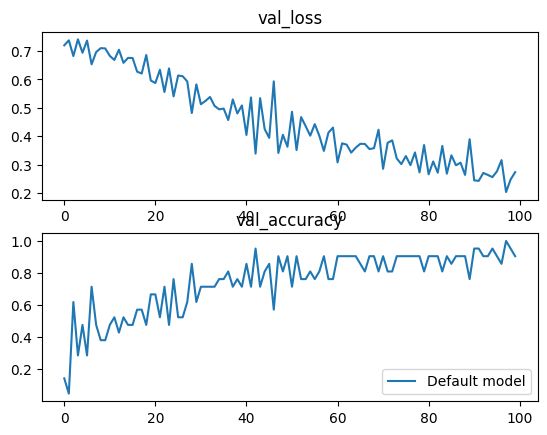

<Figure size 640x480 with 0 Axes>

In [46]:
plots = init_plot()

his = compile_and_fit(
    Sequential(
    [
        Dense(60, input_dim=60, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))
append_to_plot(plots, his, "Default model")

finalize_plot()

Далее необходимо уменьшить размер входного слоя в 2 раза. 
Для этого из 60 единиц входных данных оставим 30. Переберём небольшое число значений - в интервалах [0;30], [5;35], [10:40] ... [30;60]

Наиболее оптимальные результаты получаем при использовании данных из интервала [5;35], будем использовать их в дальнейшем

val_loss:  0.4229028820991516  loss:  0.3608514666557312  val_accuracy:  0.9047619104385376  accuracy:  0.8609625697135925
val_loss:  0.27864623069763184  loss:  0.37659719586372375  val_accuracy:  1.0  accuracy:  0.8609625697135925
val_loss:  0.5512053966522217  loss:  0.3575291335582733  val_accuracy:  0.761904776096344  accuracy:  0.8823529481887817
val_loss:  1.5030088424682617  loss:  0.3233799338340759  val_accuracy:  0.2857142984867096  accuracy:  0.893048107624054
val_loss:  0.8348531126976013  loss:  0.32842105627059937  val_accuracy:  0.380952388048172  accuracy:  0.866310179233551
val_loss:  0.858856737613678  loss:  0.3483588993549347  val_accuracy:  0.380952388048172  accuracy:  0.866310179233551
val_loss:  0.7281212210655212  loss:  0.3911871612071991  val_accuracy:  0.4761904776096344  accuracy:  0.8449198007583618


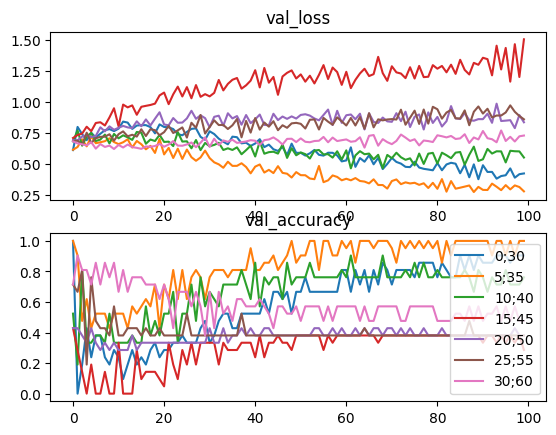

<Figure size 640x480 with 0 Axes>

In [47]:
plots = init_plot()

# Перебираем интервалы
for X2 in [0, 5, 10, 15, 20, 25, 30]:
    X = dataset[:,X2:X2 + 30].astype(float)
    his = compile_and_fit(
        Sequential(
        [
            Dense(60, input_dim=30, activation='relu'),
            Dense(1, activation='sigmoid')
        ]))
    append_to_plot(plots, his, str(X2) + ";" + str(X2 + 30))

finalize_plot()

X = dataset[:,5:35].astype(float) # Лучшие результаты

Наиболее оптимальные результаты получаем при использовании данных из интервала [5;35], будем использовать их в дальнейшем

Далее добавим скрытый слой Dense с 15 нейронами в архитектуру сети и сравним результаты работы сети с исходной сетью (Назовём новую сеть model_2):

val_loss:  0.22221696376800537  loss:  0.2529221475124359  val_accuracy:  0.9523809552192688  accuracy:  0.903743326663971
val_loss:  0.3173670172691345  loss:  0.18427282571792603  val_accuracy:  0.8571428656578064  accuracy:  0.9411764740943909


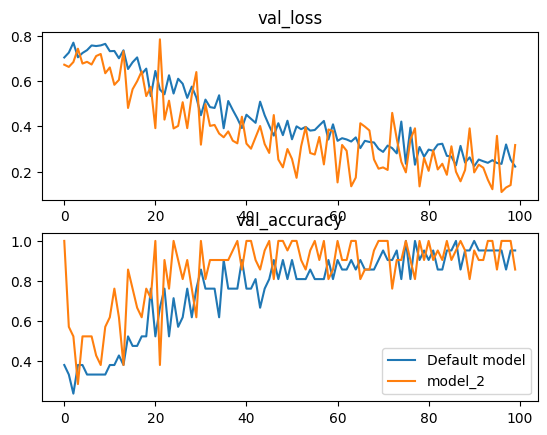

<Figure size 640x480 with 0 Axes>

In [51]:
plots = init_plot()

# Исходная сеть
X = dataset[:,0:60].astype(float)
his = compile_and_fit(
    Sequential(
    [
        Dense(60, input_dim=60, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))
append_to_plot(plots, his, "Default model")

# Сеть с дополнительным слоем и входным с числом нейронов в 2 раза меньше чем в исходной модели
X = dataset[:,5:35].astype(float) 
his = compile_and_fit(
    Sequential(
    [
        Dense(60, input_dim=30, activation='relu'),
        Dense(15, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))
append_to_plot(plots, his, "model_2")

finalize_plot()

Можно заметить что новая сеть с дополнительным слоем и уменьшенным числом нейронов на входном слое выдаёт намного лучшие результаты чем исходная сеть 

Исследуем влияние числа скрытых слоёв и числа нейронов на скрытых слоях
Добавим сети:
- model_3 - в архитектуру сети model_2 добавлено изменение - в скрытом слое вместо 15 нейронов используем 30 нейронов
- model_4 - в архитектуру сети model_2 добавлен ещё один скрытый слой - с 30 нейронами
- model_5 - в архитектуру сети model_2 добавлен ещё один скрытый слой - с 30 нейронами + один из слоёв вместо 15 нейронов имеет 30 нейронов

val_loss:  0.07175803929567337  loss:  0.15652453899383545  val_accuracy:  1.0  accuracy:  0.9679144620895386
val_loss:  0.0457855649292469  loss:  0.07271785289049149  val_accuracy:  1.0  accuracy:  0.9893048405647278
val_loss:  0.0752621442079544  loss:  0.07727887481451035  val_accuracy:  1.0  accuracy:  0.9679144620895386
val_loss:  0.07310628890991211  loss:  0.021817928180098534  val_accuracy:  0.9523809552192688  accuracy:  1.0


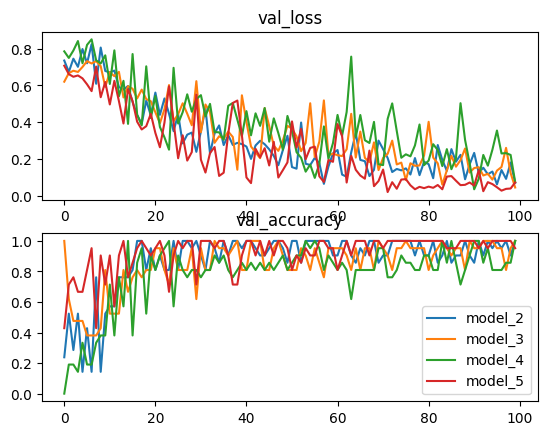

<Figure size 640x480 with 0 Axes>

In [52]:
plots = init_plot()

his = compile_and_fit(
    Sequential(
    [
        Dense(60, input_dim=30, activation='relu'),
        Dense(15, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))
append_to_plot(plots, his, "model_2")

his = compile_and_fit(
    Sequential(
    [
        Dense(60, input_dim=30, activation='relu'),
        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))
append_to_plot(plots, his, "model_3")

his = compile_and_fit(
    Sequential(
    [
        Dense(60, input_dim=30, activation='relu'),
        Dense(15, activation='relu'),
        Dense(15, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))
append_to_plot(plots, his, "model_4")

his = compile_and_fit(
    Sequential(
    [
        Dense(60, input_dim=30, activation='relu'),
        Dense(30, activation='relu'),
        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))
append_to_plot(plots, his, "model_5")

finalize_plot()

Здесь можно заметить, что наибольшую выгоду получаем в сети model_3, то есть при увеличении числа нейронов на одном из скрытых слоёв до 30. Остальные архитектуры не показали улучшения результатов